# NLP Analysis Script
## What it do
- Takes in a set of articles in a csv file
- Using a previous database of articles, finds keywords of each mew article
- Finds similarities and sentiments of each article
- Outputs CSV of all of this data

In [2]:
# import the necessary libraries

def run():
    import pandas as pd
    import os, os.path
    import re
    import nltk
    import numpy as np
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.sentiment import SentimentIntensityAnalyzer
    from collections import Counter
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import TfidfTransformer
    from scipy.sparse import coo_matrix
    from numpy import mean

    # import the kaggle news_ref
    news_ref = pd.read_csv("../kaggle_archive/articles1.csv")

    # rename the text column, shorten
    news_ref = news_ref.rename(columns={"content":'text'})
    news_ref = news_ref.head(1000)

    # get the API-obtained news articles (here it's just kaggle)
    news = pd.read_csv("../kaggle_archive/articles2.csv")
    news = news.rename(columns={"content":'text'})
    n_articles = 30
    news = news.head(n_articles)

    # get the word count for each article
    news_ref['word_count'] = news_ref['text'].apply(lambda x: len(x.split(" ")))
    news['word_count'] = news['text'].apply(lambda x: len(x.split(" ")))

    # creating a list of stopwords and adding custom stopwords
    stop_words = set(stopwords.words("english"))
    new_words = []
    stop_words = stop_words.union(new_words)

    # create a corpus to store the words in
    corpus_ref = []
    corpus = []

    # clean the text (reference)
    for i in range(len(news_ref)):

        # remove punctutation
        text = re.sub('[^a-zA-Z]',' ', news_ref['text'][i])

        # convert to lowercase
        text = text.lower()

        # remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)

        # convert to list from string
        text = text.split()

        # stem
        ps = PorterStemmer()

        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words]
        text = " ".join(text)
        corpus_ref.append(text)

    # clean the text (API)
    for i in range(len(news)):

        # remove punctutation
        text = re.sub('[^a-zA-Z]',' ', news['text'][i])

        # convert to lowercase
        text = text.lower()

        # remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)

        # convert to list from string
        text = text.split()

        text = [lem.lemmatize(word) for word in text if not word in stop_words]
        text = " ".join(text)
        corpus.append(text)

    # get the vocabulary keys, set tf-idf parameters
    cv = CountVectorizer(max_df = .8,stop_words=stop_words,max_features=10000, ngram_range=(1,3))
    X = cv.fit_transform(corpus+corpus_ref)

    # start tf-idf
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(X)

    # get feature names from the kaggle news_ref
    feature_names=cv.get_feature_names()



    def checkForRepeats(keywords,conf):
        words = []
        confs = []
        repeat = 0
        for i in range(len(keywords)):
            for j in range(len(keywords)):
                if (i != j) and (keywords[i] in keywords[j]):
                    repeat = 1
            if repeat == 0:
                words.append(keywords[i])
                confs.append(conf[i])
            repeat = 0
        return [words, confs]

    # set number of keywords
    n_keywords = 5

    # cosine similarity of the articles we want to look at
    def get_cosine_sim(*strs): 
        vectors = [t for t in get_vectors(*strs)]
        return cosine_similarity(vectors)

    def get_vectors(*strs):
        text = [t for t in strs]
        vectorizer = CountVectorizer(text)
        vectorizer.fit(text)
        return vectorizer.transform(text).toarray()

    # do the cosine sim for 9 articles (the max we'd be doing)
    sims = get_cosine_sim(*corpus[:n_articles])
    sim = []
    for i in range(n_articles):
        sim.append(np.mean(sims[i][np.arange(len(sims[i]))!=i]))

    # initialize the sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # function for sorting tf_idf in descending order
    def sort_coo(coo_matrix):
        tuples = zip(coo_matrix.col, coo_matrix.data)
        return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

    # get the feature names and tf-idf score of top n items
    def extract_topn_from_vector(feature_names, sorted_items, topn=10):

        # use only top n items from vector
        sorted_items = sorted_items[:topn]

        score_vals = []
        feature_vals = []

        # word index and corresponding tf-idf score
        for idx, score in sorted_items:

            # keep track of feature name and its corresponding score
            score_vals.append(round(score, 3))
            feature_vals.append(feature_names[idx])

        # create a tuples of feature,score
        # results = zip(feature_vals,score_vals)
        results= {}
        for idx in range(len(feature_vals)):
            results[feature_vals[idx]]=score_vals[idx]

        return results

    # create lists to return results
    words = []
    sentiments = []
    confs = []

    # iterate through the articles to get keywords and sentiment
    for i in range(n_articles):

        # fetch document for which keywords needs to be extracted
        doc=corpus[i]

        #generate tf-idf for the given document
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

        # sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())

        # extract only the top n; n here is 10
        keywords=extract_topn_from_vector(feature_names,sorted_items,n_keywords)

        # convert keywords to format, check for repeats
        keys = list(keywords.items())
        conf = [i[1] for i in keys]
        keys = [i[0] for i in keys]
        [keys, conf] = checkForRepeats(keys,conf)

        # gets the sentiment
        sent = sia.polarity_scores(corpus[i])
        sent = sent.get('compound')

        # add to lists
        words.append(keys)
        sentiments.append(sent)
        confs.append(conf)

        #print
    #     print("\nArticle: ",i)
    #     print("\nSentiment: ",sent)
    #     print("\nKeywords: ")
    #     for i in range(len(keys)):
    #         print(keys[i],conf[i])

    # print(len(sentiments))
    # print(keys)
    # print(len(words))
    # print(confs)
    # print(len(confs))
    # print(len(sim))

    # add outputs to pandas database    
    outputs = pd.DataFrame({'sentiment': sentiments, 'keywords': words,'conf':confs,'similarity':sim})
    return pd.concat([news,outputs],axis=1)

In [3]:
new = run()
new.head(5)

C:\Users\escho\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass input=['patriot day peter berg new thriller recreates boston marathon bombing ensuing manhunt followed surprisingly oblique morally ambiguous movie typically straightforward filmmaker patriot day take unexpectedly cynical view chaos rash bureaucratic infighting followed bombing question whether berg intended message grim running time movie celebrates men ground helped bring bomber justice glimpse something complicated jingoism really linger scene best illustrates dichotomy come late patriot day search one bomber dzhokhar tsarnaev intensifies brother wife katherine melissa benoist brought interrogation connection case asks lawyer protesting right steely interviewer khandi alexander tuts honey got shit hollywood line intended provoke big cheer audience despite queasy legal undertone film present cheesy line questioning go nowhere interrogator exit shrug movie note katherine never charged crime 

,Unnamed: 0,id,title,publication,author,date,year,month,url,text,word_count,sentiment,keywords,conf,similarity
0,53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r...",921,-0.9550,"[patriot day, saunders, film, tsarnaev]","[0.424, 0.318, 0.216, 0.199]",0.078859
1,53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ...",1386,0.9953,"[eukaryote, ettema, cell, microbe, gene]","[0.53, 0.417, 0.291, 0.265, 0.162]",0.131039
2,53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...,896,-0.9129,"[finch, obama, empathy, set, critic]","[0.748, 0.173, 0.129, 0.102, 0.094]",0.160613
3,53296,73475,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017.0,1.0,NaN,Updated on January 11 at 5:05 p. m. In his fir...,998,0.9878,"[press conference, trump, dossier, reporter]","[0.257, 0.256, 0.256, 0.155]",0.194207
4,53297,73476,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017.0,1.0,NaN,Updated at 12:25 p. m. After months of equivoc...,404,0.9349,"[hacking, russian, cyberattacks, national comm...","[0.258, 0.25, 0.241, 0.202]",0.154178


In [4]:
# inputs: dataframe of articles of similar topics, n= nth time this function is being called (used for spacing)
# output: saves graphs, returns HTML for group of articles
def getGroupHTML(new, n):
    import os, os.path
    import re
    import nltk
    import numpy as np
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.sentiment import SentimentIntensityAnalyzer
    from collections import Counter
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import TfidfTransformer
    from scipy.sparse import coo_matrix
    from numpy import mean

    # gets some column vectors
    len(new)
    titles = []
    text = []
    sentiment = []
    sentiment_abs = []
    similarity = []
    keywords = []
    sia = SentimentIntensityAnalyzer()
    for i in range(len(new)):
        titles.append(new['title'][i])
        text.append(new['text'][i])
        similarity.append(new['similarity'][i])
        sent = sia.polarity_scores(text[i])
        sentiment.append(sent.get('compound'))
        sentiment_abs.append(abs(sent.get('compound')))
        keywords.append(new['keywords'][i])
        text.append

    words = []
    for i in range(len(keywords)):
        for j in range(len(keywords[i])):
            words.append(keywords[i][j])

    values, counts = np.unique(words,return_counts=True)
    inds = np.argsort(counts)[::-1]
    top_keywords = values[inds]
    top_keywords_5 = top_keywords[:5]

    # find average of similarity
    sim_avg = np.mean(similarity)

    # gets the title of the most neutral article
    neutral_title = titles[sentiment_abs.index(min(sentiment_abs))]

    # average sentiment
    sent_avg = np.mean(sentiment)

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure, show, cm
    from numpy import arange
    from numpy.random import rand

    def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):

        phi = direction * np.pi / 2
        v = np.array([np.cos(phi), np.sin(phi)])
        X = np.array([[v @ [1, 0], v @ [1, 1]],
                      [v @ [0, 0], v @ [0, 1]]])
        a, b = cmap_range
        X = a + (b - a) / X.max() * X
        im = ax.imshow(X, extent=extent, interpolation='bicubic',
                       vmin=0, vmax=1, **kwargs)
        return im


    def gradient_bar(ax, x, y, width=0.5, bottom=0):
        for left, top in zip(x, y):
            right = left + width
            gradient_image(ax, extent=(left, right, bottom, top),
                           cmap=plt.cm.binary, cmap_range=(1, 1))

    xmin, xmax = xlim = -1,1
    ymin, ymax = ylim = 0, 1

    fig, ax = plt.subplots()
    ax.set(xlim=xlim, ylim=ylim, autoscale_on=False,)

    # background image
    gradient_image(ax, direction=45, extent=(0, 1, 0, 1), transform=ax.transAxes,
                   cmap=plt.cm.RdYlGn, cmap_range=(0.2, .8))

    # make sentiment image
    
    n = "% s" % n
        
        
    x = [sent_avg, sent_avg]
    y = [0,1]
    ax.axis('off')
    ax.set_title("Sentiment",fontsize=36)
    gradient_bar(ax, x, y, width=0.15)
    ax.set_aspect('auto')
    sentiment_plot = "sentiment" + n + ".png"
    fig.savefig(sentiment_plot)
    # plt.show()

    # background image
    gradient_image(ax, direction=45, extent=(0, 1, 0, 1), transform=ax.transAxes,
                   cmap=plt.cm.Blues, cmap_range=(0, .5))

    xmin, xmax = xlim = 0,1
    ax.set(xlim=xlim, ylim=ylim, autoscale_on=False,)

    # make similarity image

    
    x = [sim_avg, sim_avg]
    y = [0,1]
    ax.axis('off')
    ax.set_title("Similarity",fontsize=36)
    gradient_bar(ax, x, y, width=0.075)
    ax.set_aspect('auto')
    similarity_plot = "similarity" + n + ".png"
    fig.savefig(similarity_plot)
    # plt.show()

#     print("Neutral title: ", neutral_title)
#     print("Average sentiment: ", sent_avg)
#     print("Overall similarity: ", sim_avg)
#     print("Top keywords: ", top_keywords_5)

    # prepare some things for the HTML file
    formatted_kwords = "Keywords: "
    for i in top_keywords_5:
        if i != top_keywords_5[-1]:
            formatted_kwords = formatted_kwords + i + ", "
        else:
            formatted_kwords = formatted_kwords + i



    # append important article info
    f = open("email_content.html","a")
    article_info = "<h2>{title}</h2><h3>{keywords}</h3><p><div class=\"row\"><div class=\"column\"><img src={sentiment_plot} alt=\"sentiment\" style=width:\"200\" height:\"100\"></div><div class=\"column\"><img src={similarity_plot} alt=\"similarity\" style=width:\"200\"height:\"100\"></div></div></p><p>Continue on <a href=\"http://127.0.0.1:5000/{url}\">truli</a>"
    article_format = article_info.format(title=neutral_title,keywords=formatted_kwords,sentiment_plot=sentiment_plot, similarity_plot=similarity_plot,url="Story"+str(int(0)+1))
    f.write(article_format)
    f.close()



In [5]:
# get the big HTML file
import pandas as pd

with open("imports.html","r") as fp:
    imports = fp.read()

# save the important info in an HTML file
# truli news header
f = open("email_content.html","w")
newsletter_top = "{imports}<h1>Truli Newsletter</h1>Thank you for subscribing to Truli!"
top_format = newsletter_top.format(imports=imports)
f.write(top_format)
f.close()

# add the body of the html, this is where we run the script
''' run script of important topics, get pandas database new'''
for i in range(5):
    i_str = "% s" % i
    file_name = "stories/story" + i_str
    new = pd.read_csv(file_name)
    getGroupHTML(new,i)

# put stuff at bottom of file
f = open("email_content.html","a")
f.write("</body></html>")
f.close()

# display the HTML file
f = open("email_content.html","r")
print(f.read())

FileNotFoundError: [Errno 2] File stories/story0 does not exist: 'stories/story0'

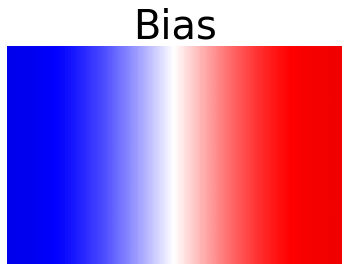

,names,bias,reliability,category
0,The Huffington Post,-13.66,39.39,-2
1,MSNBC,-16.01,43.84,-2
2,Newsweek,-12.62,38.37,-2
3,CNN,-9.95,43.73,-1
4,Reuters,-7.54,49.39,-1
5,Politico,-7.88,45.03,-1
6,NBC,-8.50,46.47,-1
7,Bloomberg,-3.71,46.26,-1
8,The Washington Post,-10.58,43.53,-1
9,USA Today,-5.22,46.02,0


In [124]:
# for a given article index, get the political bias of that source and create the metric plot
def getBiasChart(df,i):
    import numpy as np
    from numpy import mean

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure, show, cm
    from numpy import arange
    from numpy.random import rand

    def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):

        phi = direction * np.pi / 2
        v = np.array([np.cos(phi), np.sin(phi)])
        X = np.array([[v @ [1, 0], v @ [1, 1]],
                      [v @ [0, 0], v @ [0, 1]]])
        a, b = cmap_range
        X = a + (b - a) / X.max() * X
        im = ax.imshow(X, extent=extent, interpolation='bicubic',
                       vmin=0, vmax=1, **kwargs)
        return im


    def gradient_bar(ax, x, y, width=0.5, bottom=0):
        for left, top in zip(x, y):
            right = left + width
            gradient_image(ax, extent=(left, right, bottom, top),
                           cmap=plt.cm.binary, cmap_range=(1, 1))

    xmin, xmax = xlim = -20,20
    ymin, ymax = ylim = 0, 1

    fig, ax = plt.subplots()
    ax.set(xlim=xlim, ylim=ylim, autoscale_on=False,)

    # background image
    gradient_image(ax, direction=45, extent=(0, 1, 0, 1), transform=ax.transAxes,
                   cmap=plt.cm.seismic, cmap_range=(0.2, .8))

    # get the media bias of that source
    
    source_names = ["The Huffington Post", "MSNBC", "Newsweek", "CNN", "Reuters", "Politico", "NBC", "Bloomberg", "The Washington Post", "USA Today", "Associated Press", "The Hill", "CBS News", "ABC News", "Al Jazeera English", "BBC News", "Axios", "Ars Technica", "Fortune", "The Washington Times", "Business Insider", "The Globe and Mail", "The Wall Street Journal", "The American Conservative", "Fox News", "National Review"]
    source_bias = [-13.66, -16.01, -12.62, -9.95, -7.54, -7.88, -8.5, -3.71, -10.58, -5.22, -2.36, 0.09, -3.38, -4.57, -8.66, -6.35, -9.34, -0.76, 3.5, 15, 2.42, -4.92, 3.38, 13.59, 16.80, 18.09]
    source_reliability = [39.39, 43.84, 38.37, 43.73, 49.39, 45.03, 46.47, 46.26, 43.53, 46.02, 51.23, 44.75, 49.48, 48.62, 46.06, 43.75, 44.29, 46.1, 45.81, 24.3, 41.22, 46.36, 47.45, 31.15, 30.14, 30.7]
    source_category = [-2,-2,-2,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2]
    source_info = {'names': source_names, 'bias': source_bias, 'reliability': source_reliability, 'category': source_category}
    sources_list = pd.DataFrame(data = source_info)
    sources_list.head(26)
    
    source = df['publication'][i]
    
    if source in sources_list.values:
        source_bias_index = sources_list.bias[sources_list.names==source].index[0]
        source_bias = sources_list['bias'][source_bias_index]
    else:
        source_bias = 100
    


    # make sentiment image
    x = [source_bias, source_bias]
    y = [0,1]
    ax.axis('off')
    ax.set_title("Bias",fontsize=40)
    gradient_bar(ax, x, y, width=2)
    ax.set_aspect('auto')
    fig.savefig("bias.png")
    plt.show()

    
getBiasChart(new,5)
sources_list.head(26)